In [1]:
import pyads
from ctypes import sizeof
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, Longitude, SkyCoord, get_sun, AltAz
from astropy import units as u
import datetime
from datetime import timedelta
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

from random import randint, uniform, randrange

from PyAstronomy.pyasl import eq2hor

In [2]:
'''
ADSSTATES:
{
    Invalid = 0,
    Idle = 1,
    Reset = 2,
    Init = 3,
    Start = 4,
    Run = 5,
    Stop = 6,
    SaveConfig = 7,
    LoadConfig = 8,
    PowerFailure = 9,
    PowerGood = 10,
    Error = 11,
    Shutdown = 12,
    Suspend = 13,
    Resume = 14,
    Config = 15,
    Reconfig = 16,
    Maxstates = 17,
}
'''

'\nADSSTATES:\n{\n    Invalid = 0,\n    Idle = 1,\n    Reset = 2,\n    Init = 3,\n    Start = 4,\n    Run = 5,\n    Stop = 6,\n    SaveConfig = 7,\n    LoadConfig = 8,\n    PowerFailure = 9,\n    PowerGood = 10,\n    Error = 11,\n    Shutdown = 12,\n    Suspend = 13,\n    Resume = 14,\n    Config = 15,\n    Reconfig = 16,\n    Maxstates = 17,\n}\n'

In [17]:
# for simple connection follow instructions of:
# http://soup01.com/en/2022/06/02/beckhoffusing-python-to-communicate-with-twincat-by-ads/

ads_net_id = '134.76.204.249.1.1' # net_id of PLC -> look at SYSTEM/Tasks/Routes
plc = pyads.Connection(ads_net_id, pyads.PORT_TC3PLC1) # create plc object with net_id and port 851
'''
print("Connecting to TwinCAT PLC..")
plc.open() # open plc connection
print("Current connection status:",plc.is_open)
print("Current Status:",plc.read_state())

print("Closing the Connections..")
plc.close()
print("Current Status:",plc.is_open)
'''
def test_JD2LST(time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m).geodetic
    #LST time
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')


    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("height", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    lst1_b = plc.get_symbol('MAIN.lst1')

    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'height':loc[2]})
    jd1_b.write(timeJD_astro)
    # change estate to execute test -> 5 == test_state.JD2LST
    plc.write_by_name(data_name='MAIN.estate', value=5,plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.01) # new cycle of twincat
    # get LST value
    LST_beck =  lst1_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    return np.array([LST_astro.degree, LST_beck, LST_astro.degree-LST_beck])

def test_EQ2HOR(coord_eq, time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    
    # obs location
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m)
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')
    #------------------------------------------------------------------------------------------
    # Astropy coord-trafo
    coord_eq_astro = SkyCoord(ra=coord_eq[0]*u.degree, dec=coord_eq[1]*u.degree, frame="icrs")
    
    altaz_frame = AltAz(location=loc_astro, obstime=Time(time))
    coord_hor_astro = coord_eq_astro.transform_to(altaz_frame)
    
    #------------------------------------------------------------------------------------------
    # PyAstronomy coord-trafo (like STELLA from IDL (should be the same code but different languages))
    # https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/eq2hor.html#convert-celestial-coordinates-ra-dec-into-local-horizon-coordinates-alt-az
    alt_pyastro, az_pyastro, rest = eq2hor(timeJD_astro, coord_eq[0], coord_eq[1], lon=loc[1], lat=loc[0], alt=loc[2], B1950=False, precess=True, nutate=True, aberration=True, refract=False)

    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    coord_in_b = plc.get_symbol('MAIN.coord_eq', structure_def=(("ra", pyads.PLCTYPE_LREAL,1),("dec", pyads.PLCTYPE_LREAL,1)))
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("altitude", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    coord_out_b = plc.get_symbol('MAIN.coord_hor', structure_def=(("alt", pyads.PLCTYPE_LREAL,1),("az", pyads.PLCTYPE_LREAL,1)))
    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'altitude':loc[2]})
    jd1_b.write(timeJD_astro)
    coord_in_b.write({'ra':coord_eq[0], 'dec':coord_eq[1]})
    # change estate to execute test -> 1 == test_state.EQ2HOR
    plc.write_by_name(data_name='MAIN.estate', value=1, plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.02) # new cycle of twincat
    
    # get ALT/AZ values
    # STELLA code
    coord_out_beck = coord_out_b.read()
    # simple code

    plc.close()
    #------------------------------------------------------------------------------------------
    
    return np.array([[coord_out_beck['alt'], coord_out_beck['az']] , [alt_pyastro[0], az_pyastro[0]], [coord_hor_astro.alt.degree, coord_hor_astro.az.degree]])

def test_HOR2EQ(coord_hor, time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    
    # obs location
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m)
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')
    #------------------------------------------------------------------------------------------
    # Astropy coord-trafo
    coord_hor_astro = SkyCoord(location=loc_astro, obstime=Time(time), alt = coord_hor[0]*u.deg, az = coord_hor[1]*u.deg, frame = 'altaz')
     
    coord_eq_astro =coord_hor_astro.transform_to('icrs')

    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    coord_in_b = plc.get_symbol('MAIN.coord_hor', structure_def=(("alt", pyads.PLCTYPE_LREAL,1),("az", pyads.PLCTYPE_LREAL,1)))
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("altitude", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    coord_out_b = plc.get_symbol('MAIN.coord_eq', structure_def=(("ra", pyads.PLCTYPE_LREAL,1),("dec", pyads.PLCTYPE_LREAL,1)))
    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'altitude':loc[2]})
    jd1_b.write(timeJD_astro)
    coord_in_b.write({'alt':coord_hor[0], 'az':coord_hor[1]})
    # change estate to execute test -> 2 == test_state.EQ2HOR
    plc.write_by_name(data_name='MAIN.estate', value=2, plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.02) # new cycle of twincat
    
    # get ALT/AZ values
    # STELLA code
    coord_out_beck = coord_out_b.read()
    # simple code

    plc.close()
    #------------------------------------------------------------------------------------------
    
    return np.array([[coord_out_beck['ra'], coord_out_beck['dec']] , [coord_eq_astro.ra.degree, coord_eq_astro.dec.degree]])
    
def test_EQ2EQ(coord_eq, time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    coord_eq_b = plc.get_symbol('MAIN.coord_eq', structure_def=(("ra", pyads.PLCTYPE_LREAL,1),("dec", pyads.PLCTYPE_LREAL,1)))
    loc0_b = plc.get_symbol('MAIN.loc0', structure_def=(("longitude", pyads.PLCTYPE_LREAL,1),("latitude", pyads.PLCTYPE_LREAL,1),("altitude", pyads.PLCTYPE_LREAL,1)))
    jd1_b = plc.get_symbol('MAIN.jd1')
    # write values to symbols
    loc0_b.write({'longitude':loc[1], 'latitude':loc[0], 'altitude':loc[2]})
    jd1_b.write(timeJD_astro)
    coord_eq_b.write({'ra':coord_eq[0], 'dec':coord_eq[1]})
    # change estate to execute test -> 3 == test_state.EQ2EQ
    plc.write_by_name(data_name='MAIN.estate', value=3, plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.04) # new cycle of twincat
    
    # get ALT/AZ values
    # STELLA code
    coord_out_beck = coord_eq_b.read()
    # simple code

    plc.close()
    #------------------------------------------------------------------------------------------
    
    return np.array([coord_out_beck['ra'], coord_out_beck['dec']])

def check_cycle_time(): # returns the actual twincat cycle time
    plc.open() # open plc connection
    cycle_time_symbol = plc.get_symbol('MAIN.cycle_time')
    cycle_time = cycle_time_symbol.read()
    plc.close()
    return cycle_time

Starting test!
Testing...
Finished!
Cycle time:  0.01


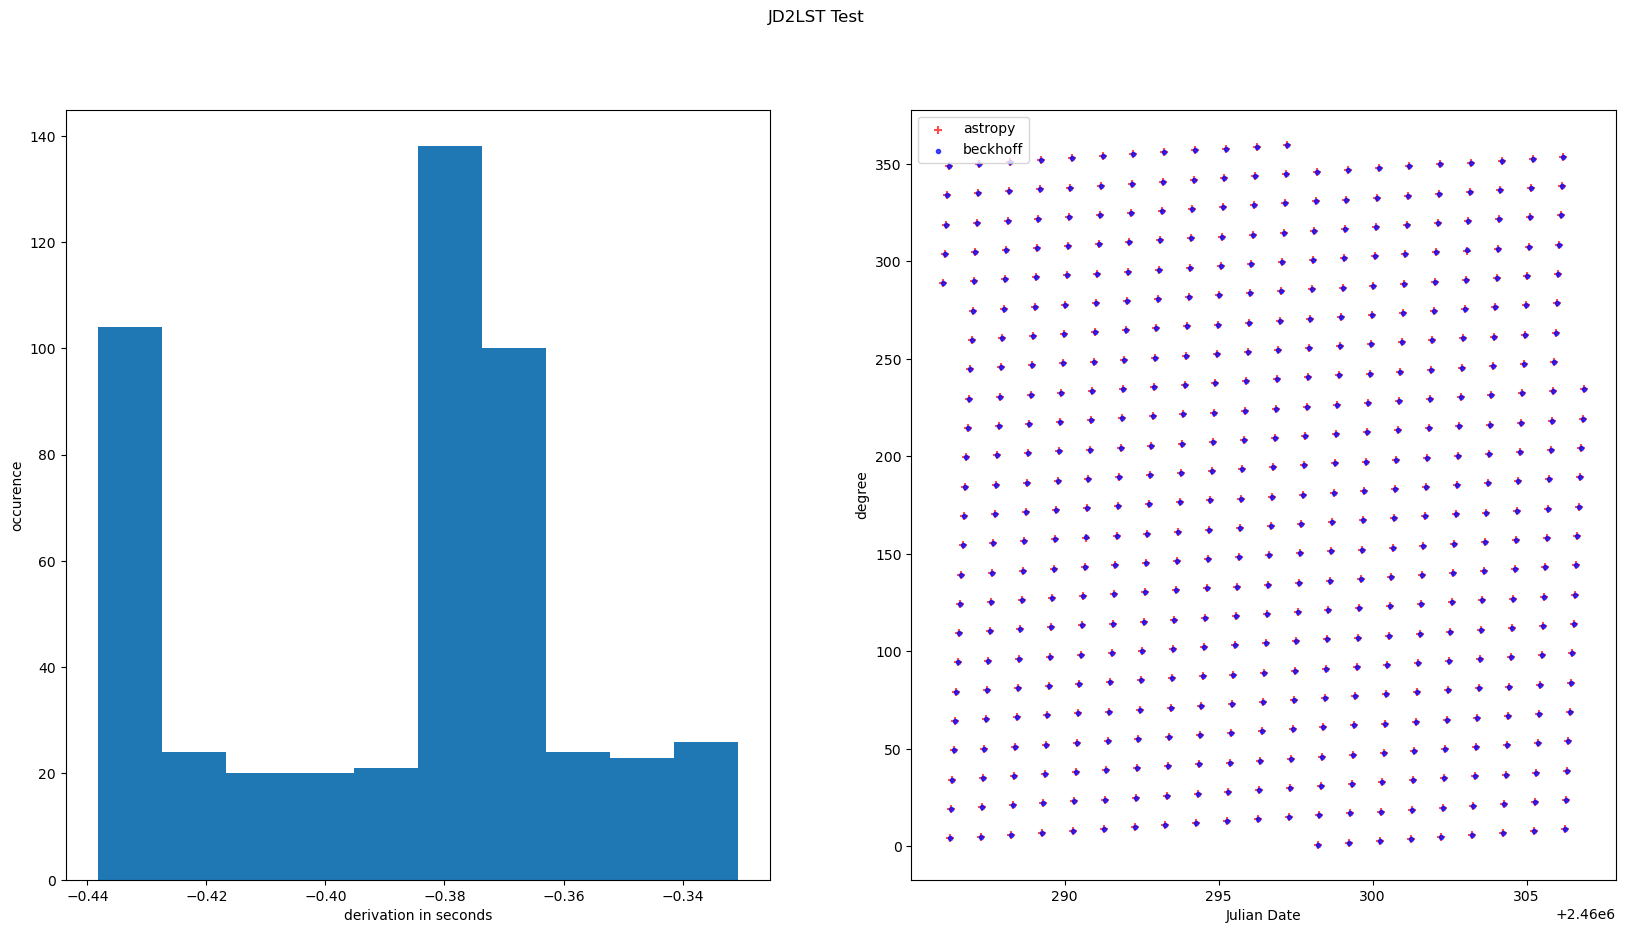

In [36]:
# test JD2LST
print('Starting test!')
now =  datetime.datetime.now()
# make time series
ts = TimeSeries(time_start=now,
                 time_delta=60 * u.min,
                 n_samples=500)
print('Testing...')
results = np.array([test_JD2LST(time) for time in ts.time])
print('Finished!')

print('Cycle time: ', check_cycle_time())
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('JD2LST Test')
axs[0].hist(results[:,2]*3600/15)
axs[0].set_xlabel('derivation in seconds')
axs[0].set_ylabel('occurence')

axs[1].scatter(ts.time.jd, results[:,0], marker='+', alpha=0.7, c='red', label='astropy')
axs[1].scatter(ts.time.jd, results[:,1], marker='.', alpha=0.7, c= 'blue', label='beckhoff')
axs[1].set_xlabel('Julian Date')
axs[1].set_ylabel('degree')
axs[1].legend()
plt.show()

# MAIN CONCLUSION

The derivation to Astropy is below half a second which seems precise for all coordinate transformations.

# EQ2HOR

In [66]:
# test for a lot of random dates, a lot of random ra/dec coordinates
# test beween 2023 and 2040 (more makes really no sense)
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

def random_data_eq():
    random_time = random_date(datetime.datetime(2023, 1, 1, 0, 0, 0), datetime.datetime(2024, 1, 1, 0, 0, 0))
    random_coord = np.array([uniform(0,359), uniform(-90,90)])
    
    return test_EQ2HOR(random_coord, random_time), random_coord, random_time

# number of tests
n_test = 500

# for each test: [diff_az_pyastro, diff_alt_pyastro], [diff_az_stella, diff_alt_stella]
# err will be in absolute arcsec -> initial as -1 for error checking
err = np.zeros([n_test,2,2]) - 1
datas = np.zeros([n_test,3,2])
coords = np.zeros([n_test,2])
times = []
# mask for on-sky (alt > 0)
mask = np.full(n_test, False)

for n in range(0,n_test):
    # get random data
    data_, coord_, time_ = random_data_eq()
    datas[n] = data_
    coords[n] = coord_
    times.append(time_)
    if data_[2,0] > 0.0:
        mask[n] = True
    # calculating differences in degrees to ASTROPY
    diff_az_pyastro = data_[2,1] - data_[1,1]
    diff_alt_pyastro = data_[2,0]-data_[1,0]

    diff_az_stella = data_[2,1]- data_[0,1]
    diff_alt_stella = data_[2,0]-data_[0,0]
    
    #err in absolute arcsec
    err[n] = np.fabs(np.array([[diff_az_pyastro,diff_alt_pyastro],[diff_az_stella,diff_alt_stella]]))*3600


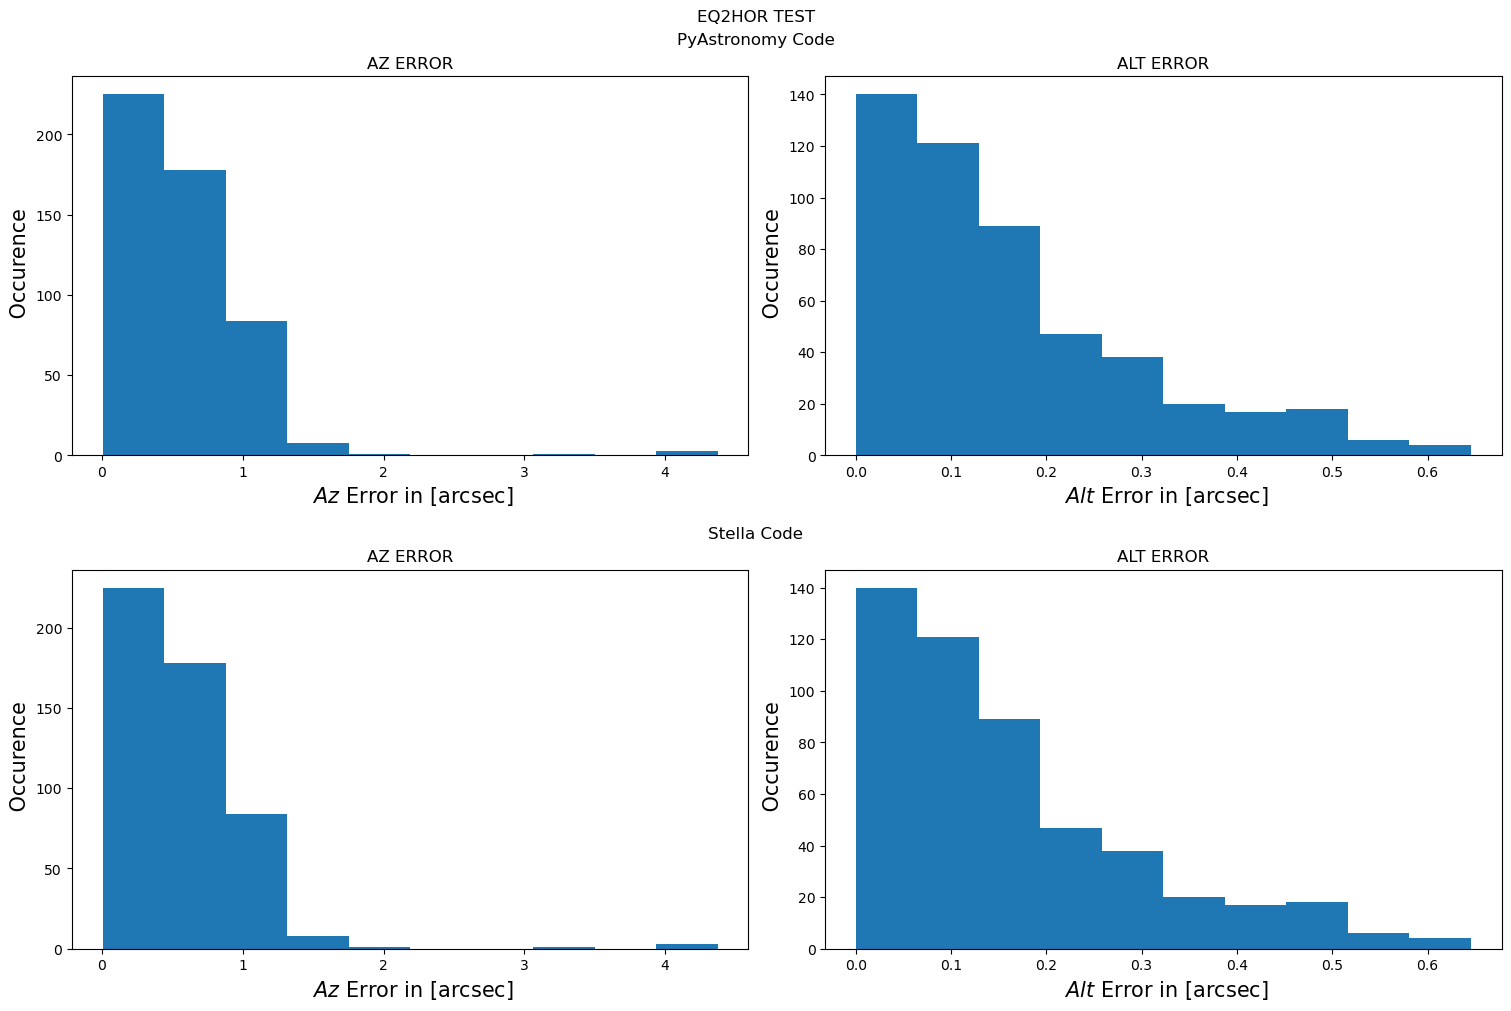

In [67]:
# create 2x1 subplots
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(15, 10))
fig.suptitle('EQ2HOR TEST')

# clear subplots
for ax in axs:
    ax.remove()

err_masked = err#[mask]
# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]
subfigs[0].suptitle('PyAstronomy Code')
axs_simple = subfigs[0].subplots(nrows=1, ncols=2)
axs_simple[0].set_title('AZ ERROR')
axs_simple[0].hist(err_masked[:,0,0])
axs_simple[0].set_xlabel(r' $Az$ Error in [arcsec]', fontsize=15)
axs_simple[0].set_ylabel(r' Occurence', fontsize=15)

axs_simple[1].set_title('ALT ERROR')
axs_simple[1].hist(err_masked[:,0,1])
axs_simple[1].set_xlabel(r' $Alt$ Error in [arcsec]', fontsize=15)
axs_simple[1].set_ylabel(r' Occurence', fontsize=15)

subfigs[1].suptitle('Stella Code')
axs_simple = subfigs[1].subplots(nrows=1, ncols=2)
axs_simple[0].set_title('AZ ERROR')
axs_simple[0].hist(err_masked[:,1,0])
axs_simple[0].set_xlabel(r' $Az$ Error in [arcsec]', fontsize=15)
axs_simple[0].set_ylabel(r' Occurence', fontsize=15)

axs_simple[1].set_title('ALT ERROR')
axs_simple[1].hist(err_masked[:,1,1])
axs_simple[1].set_xlabel(r' $Alt$ Error in [arcsec]', fontsize=15)
axs_simple[1].set_ylabel(r' Occurence', fontsize=15)
plt.show()

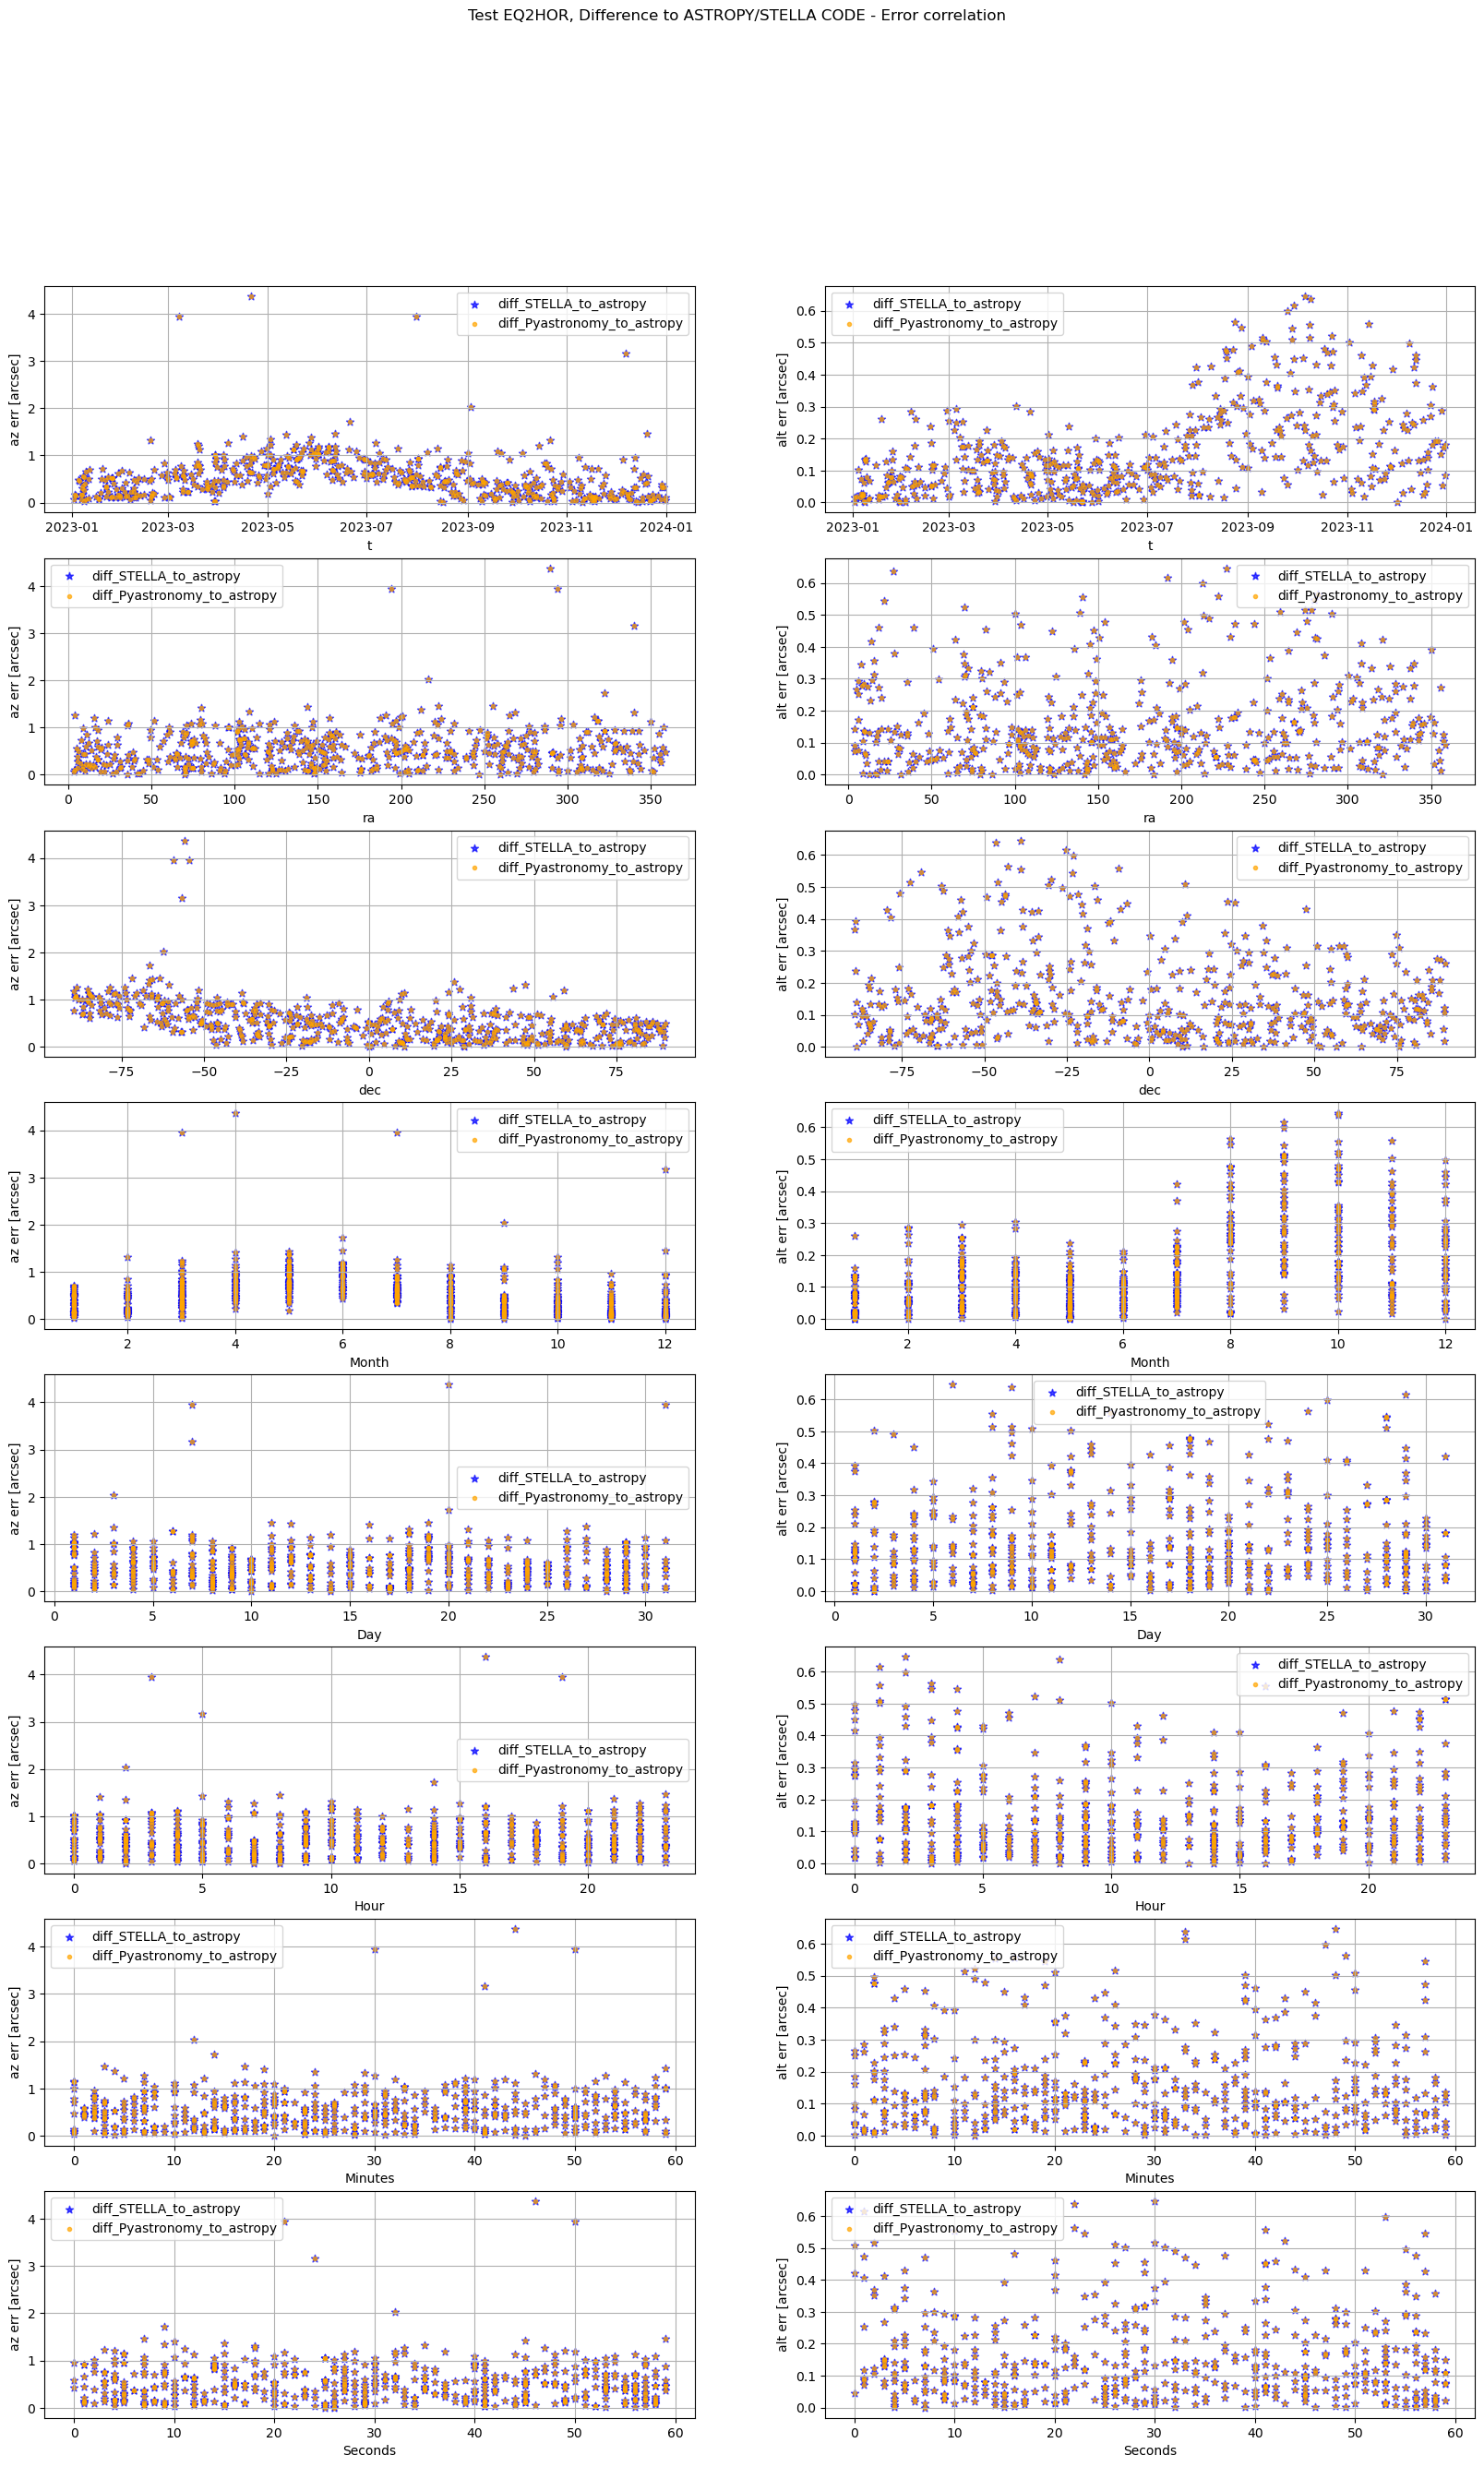

In [68]:
fig, axs = plt.subplots(8, 2, figsize=(20, 30))
fig.suptitle('Test EQ2HOR, Difference to ASTROPY/STELLA CODE - Error correlation')
axs[0,0].scatter(times, err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[0,0].scatter(times, err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('az err [arcsec]')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].scatter(times, err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[0,1].scatter(times, err[:,0,1],marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[0,1].set_xlabel('t')
axs[0,1].set_ylabel('alt err [arcsec]')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].scatter(coords[:,0], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[1,0].scatter(coords[:,0], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[1,0].set_xlabel('ra')
axs[1,0].set_ylabel('az err [arcsec]')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].scatter(coords[:,0], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[1,1].scatter(coords[:,0], err[:,0,1],marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[1,1].set_xlabel('ra')
axs[1,1].set_ylabel('alt err [arcsec]')
axs[1,1].legend()
axs[1,1].grid()

axs[2,0].scatter(coords[:,1], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[2,0].scatter(coords[:,1], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[2,0].set_xlabel('dec')
axs[2,0].set_ylabel('az err [arcsec]')
axs[2,0].legend()
axs[2,0].grid()

axs[2,1].scatter(coords[:,1], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[2,1].scatter(coords[:,1], err[:,0,1], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[2,1].set_xlabel('dec')
axs[2,1].set_ylabel('alt err [arcsec]')
axs[2,1].legend()
axs[2,1].grid()

axs[3,0].scatter([m.month for m in times], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[3,0].scatter([m.month for m in times], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[3,0].set_xlabel('Month')
axs[3,0].set_ylabel('az err [arcsec]')
axs[3,0].legend()
axs[3,0].grid()

axs[3,1].scatter([m.month for m in times], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[3,1].scatter([m.month for m in times], err[:,0,1], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[3,1].set_xlabel('Month')
axs[3,1].set_ylabel('alt err [arcsec]')
axs[3,1].legend()
axs[3,1].grid()

axs[4,0].scatter([m.day for m in times], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[4,0].scatter([m.day for m in times], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[4,0].set_xlabel('Day')
axs[4,0].set_ylabel('az err [arcsec]')
axs[4,0].legend()
axs[4,0].grid()

axs[4,1].scatter([m.day for m in times], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[4,1].scatter([m.day for m in times], err[:,0,1],marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[4,1].set_xlabel('Day')
axs[4,1].set_ylabel('alt err [arcsec]')
axs[4,1].legend()
axs[4,1].grid()

axs[5,0].scatter([m.hour for m in times], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[5,0].scatter([m.hour for m in times], err[:,0,0],marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[5,0].set_xlabel('Hour')
axs[5,0].set_ylabel('az err [arcsec]')
axs[5,0].legend()
axs[5,0].grid()

axs[5,1].scatter([m.hour for m in times], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[5,1].scatter([m.hour for m in times], err[:,0,1],marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[5,1].set_xlabel('Hour')
axs[5,1].set_ylabel('alt err [arcsec]')
axs[5,1].legend()
axs[5,1].grid()

axs[6,0].scatter([m.minute for m in times], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[6,0].scatter([m.minute for m in times], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[6,0].set_xlabel('Minutes')
axs[6,0].set_ylabel('az err [arcsec]')
axs[6,0].legend()
axs[6,0].grid()

axs[6,1].scatter([m.minute for m in times], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[6,1].scatter([m.minute for m in times], err[:,0,1], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[6,1].set_xlabel('Minutes')
axs[6,1].set_ylabel('alt err [arcsec]')
axs[6,1].legend()
axs[6,1].grid()

axs[7,0].scatter([m.second for m in times], err[:,1,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[7,0].scatter([m.second for m in times], err[:,0,0], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[7,0].set_xlabel('Seconds')
axs[7,0].set_ylabel('az err [arcsec]')
axs[7,0].legend()
axs[7,0].grid()

axs[7,1].scatter([m.second for m in times], err[:,1,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[7,1].scatter([m.second for m in times], err[:,0,1], marker='.', alpha=0.7, c='orange', label='diff_Pyastronomy_to_astropy')
axs[7,1].set_xlabel('Seconds')
axs[7,1].set_ylabel('alt err [arcsec]')
axs[7,1].legend()
axs[7,1].grid()

plt.show()

# MAIN CONCLUSION

The alt error is below two arcseconds, the az error ist mosty below 5 but there are ouliers up to 40 arcsec. Generally, the accuracy seems to drop for later times. Additionally, the high az errors seem to correlate well with dec values for |dec| ~ 45 degrees.
Author states accuracy should typically be below 1 arcsec, therefor not sure how reliable Astropy is. Erros seem systematic and not random. Similar for PyAstronomy which implements the same code only in python.

# HOR2EQ

In [65]:
# test for a lot of random dates, a lot of random alt/az coordinates
# test beween 2023 and 2040 (more makes really no sense)
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

def random_data_hor():
    random_time = random_date(datetime.datetime(2023, 1, 1, 0, 0, 0), datetime.datetime(2024, 1, 1, 0, 0, 0))
    random_coord = np.array([uniform(0,90), uniform(0,359)])
    
    return test_HOR2EQ(random_coord, random_time), random_coord, random_time

# number of tests
n_test = 500



In [68]:

# err will be in absolute arcsec -> initial as -1 for error checking
err_hor = np.zeros([n_test,1,2]) - 1
datas = np.zeros([n_test,2,2])
coords = np.zeros([n_test,2])
times = []
# mask for on-sky (alt > 0)
mask = np.full(n_test, False)

for n in range(0,n_test):
    # get random data
    data_, coord_, time_ = random_data_hor()
    datas[n] = data_
    coords[n] = coord_
    times.append(time_)
    # calculating differences in degrees to ASTROPY
    diff_dec_stella = data_[1,1]- data_[0,1]
    diff_ra_stella = data_[1,0] - data_[0,0]
    if diff_ra_stella >=180:
        diff_ra_stella = 360-diff_ra_stella
    
    #err in absolute arcsec
    err_hor[n] = np.fabs(np.array([diff_ra_stella,diff_dec_stella]))*3600

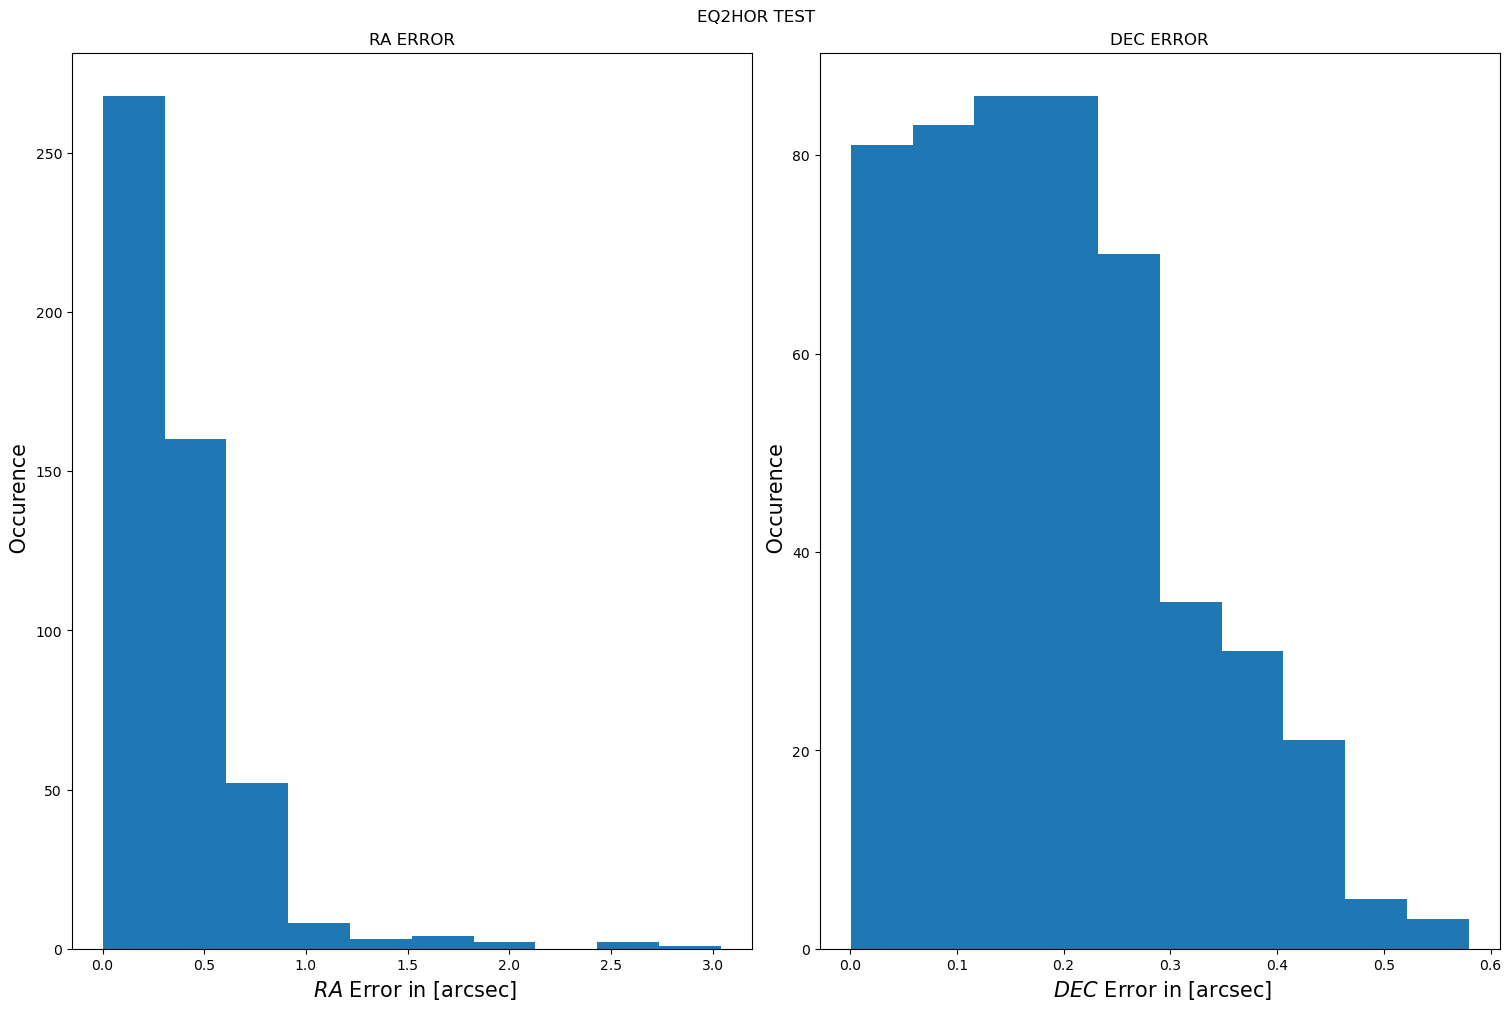

In [71]:
# create 2x1 subplot1
fig, axs_simple = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 10))
fig.suptitle('EQ2HOR TEST')



err_masked = err_hor#[mask]


axs_simple[0].set_title('RA ERROR')
axs_simple[0].hist(err_masked[:,0,0])
axs_simple[0].set_xlabel(r' $RA$ Error in [arcsec]', fontsize=15)
axs_simple[0].set_ylabel(r' Occurence', fontsize=15)

axs_simple[1].set_title('DEC ERROR')
axs_simple[1].hist(err_masked[:,0,1])
axs_simple[1].set_xlabel(r' $DEC$ Error in [arcsec]', fontsize=15)
axs_simple[1].set_ylabel(r' Occurence', fontsize=15)

plt.show()

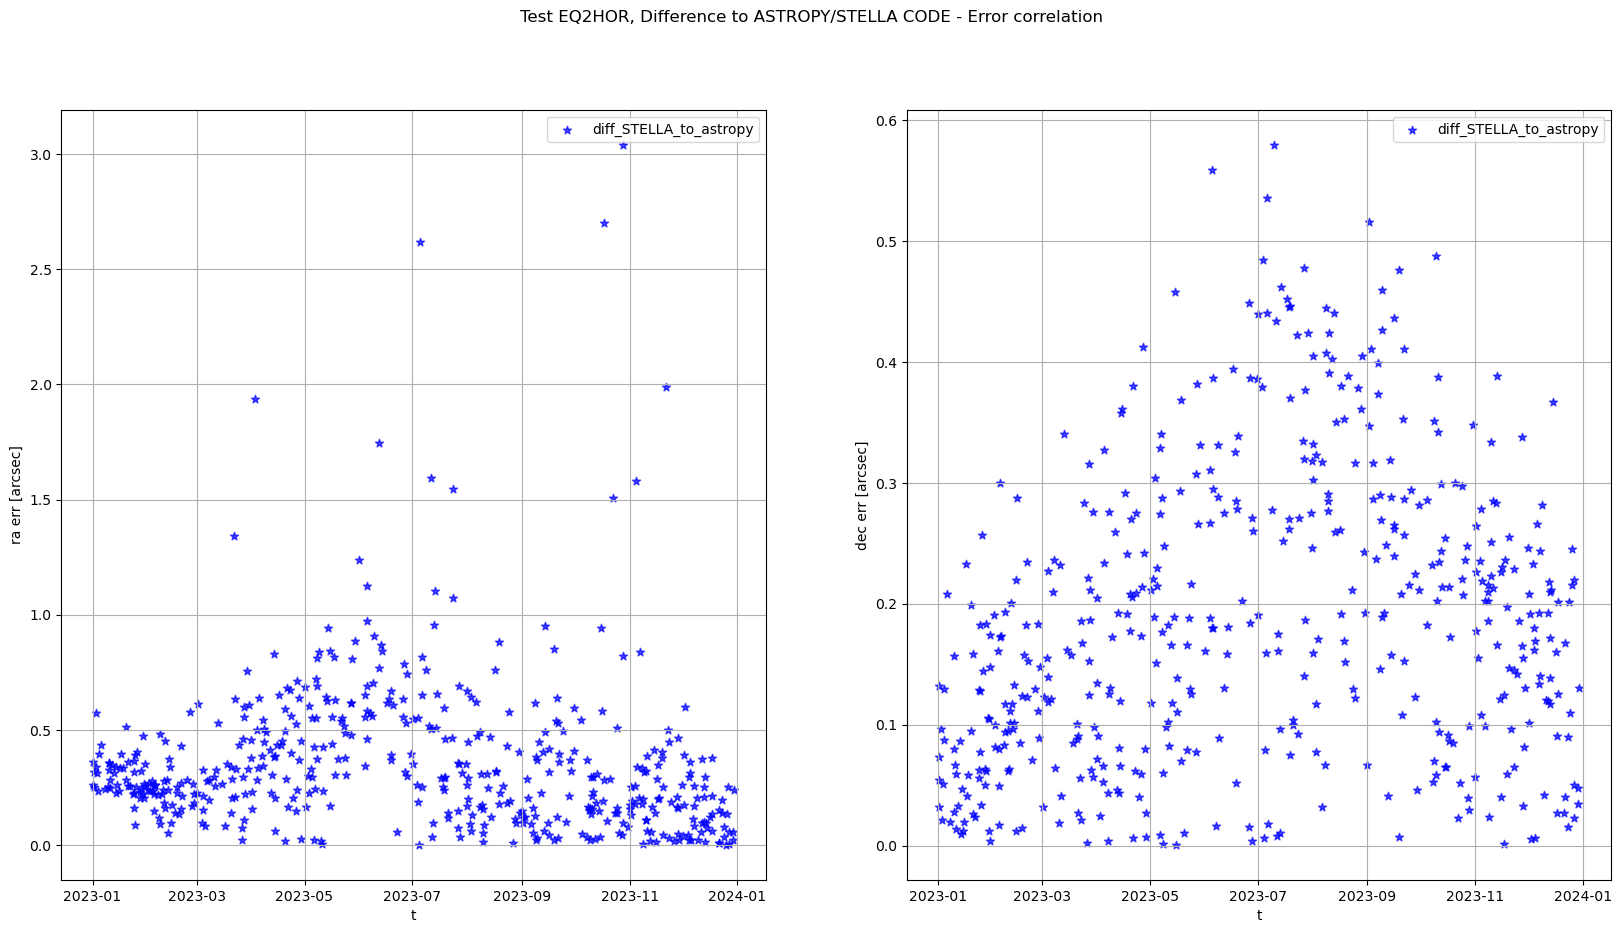

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Test EQ2HOR, Difference to ASTROPY/STELLA CODE - Error correlation')
axs[0].scatter(times, err_hor[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[0].set_xlabel('t')
axs[0].set_ylabel('ra err [arcsec]')
axs[0].legend()
axs[0].grid()

axs[1].scatter(times, err_hor[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[1].set_xlabel('t')
axs[1].set_ylabel('dec err [arcsec]')
axs[1].legend()
axs[1].grid()
plt.show()

# EQ2EQ

In [49]:
# test for a lot of random dates, a lot of random ra/dec coordinates
# test beween 2023 and 2040 (more makes really no sense)
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

def random_data_eq():
    random_time = random_date(datetime.datetime(2023, 1, 1, 0, 0, 0), datetime.datetime(2024, 1, 1, 0, 0, 0))
    random_coord = np.array([uniform(0,359),uniform(-90,90)])
    
    return random_coord, random_time

# number of tests
n_test = 100

data_in = np.zeros([n_test,2])
times = []
for n in range(0,n_test):
    # get random data
    coord_in_, time_ = random_data_eq()
    data_in[n] = coord_in_
    times.append(time_)

In [60]:

# err will be in absolute arcsec -> initial as -1 for error checking
err = np.zeros([n_test,2,2]) - 1
data_out = np.zeros([n_test,2])


for n in range(0,n_test):
    # get random data
    coord_out_ = test_EQ2EQ(data_in[n], times[n])
    data_out[n] = coord_out_
   
    # calculating differences in degrees
    diff_ra = data_in[n,0] - data_out[n,0]
    diff_dec = data_in[n,1] - data_out[n,1]
    if diff_ra >=180:
        diff_ra = 360-diff_ra

    #err in absolute arcsec
    err[n] = np.fabs(np.array([diff_ra,diff_dec]))*3600


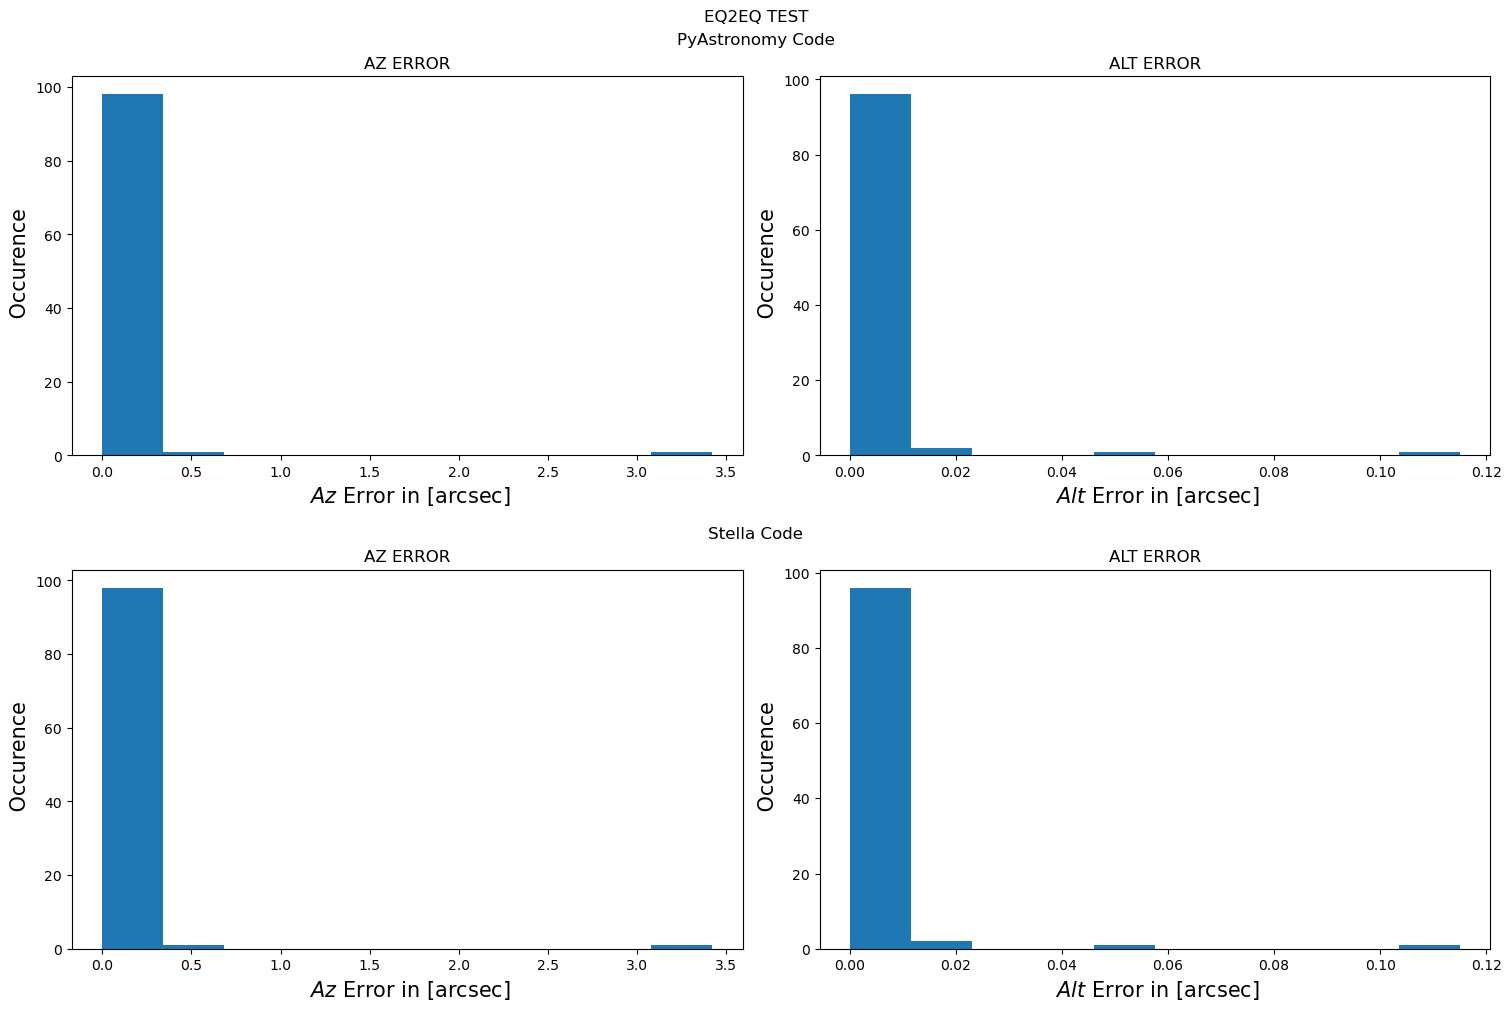

In [61]:
# create 2x1 subplots
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(15, 10))
fig.suptitle('EQ2EQ TEST')

# clear subplots
for ax in axs:
    ax.remove()

err_masked = err#[mask]
# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]
subfigs[0].suptitle('PyAstronomy Code')
axs_simple = subfigs[0].subplots(nrows=1, ncols=2)
axs_simple[0].set_title('AZ ERROR')
axs_simple[0].hist(err_masked[:,0,0])
axs_simple[0].set_xlabel(r' $Az$ Error in [arcsec]', fontsize=15)
axs_simple[0].set_ylabel(r' Occurence', fontsize=15)

axs_simple[1].set_title('ALT ERROR')
axs_simple[1].hist(err_masked[:,0,1])
axs_simple[1].set_xlabel(r' $Alt$ Error in [arcsec]', fontsize=15)
axs_simple[1].set_ylabel(r' Occurence', fontsize=15)

subfigs[1].suptitle('Stella Code')
axs_simple = subfigs[1].subplots(nrows=1, ncols=2)
axs_simple[0].set_title('AZ ERROR')
axs_simple[0].hist(err_masked[:,1,0])
axs_simple[0].set_xlabel(r' $Az$ Error in [arcsec]', fontsize=15)
axs_simple[0].set_ylabel(r' Occurence', fontsize=15)

axs_simple[1].set_title('ALT ERROR')
axs_simple[1].hist(err_masked[:,1,1])
axs_simple[1].set_xlabel(r' $Alt$ Error in [arcsec]', fontsize=15)
axs_simple[1].set_ylabel(r' Occurence', fontsize=15)
plt.show()

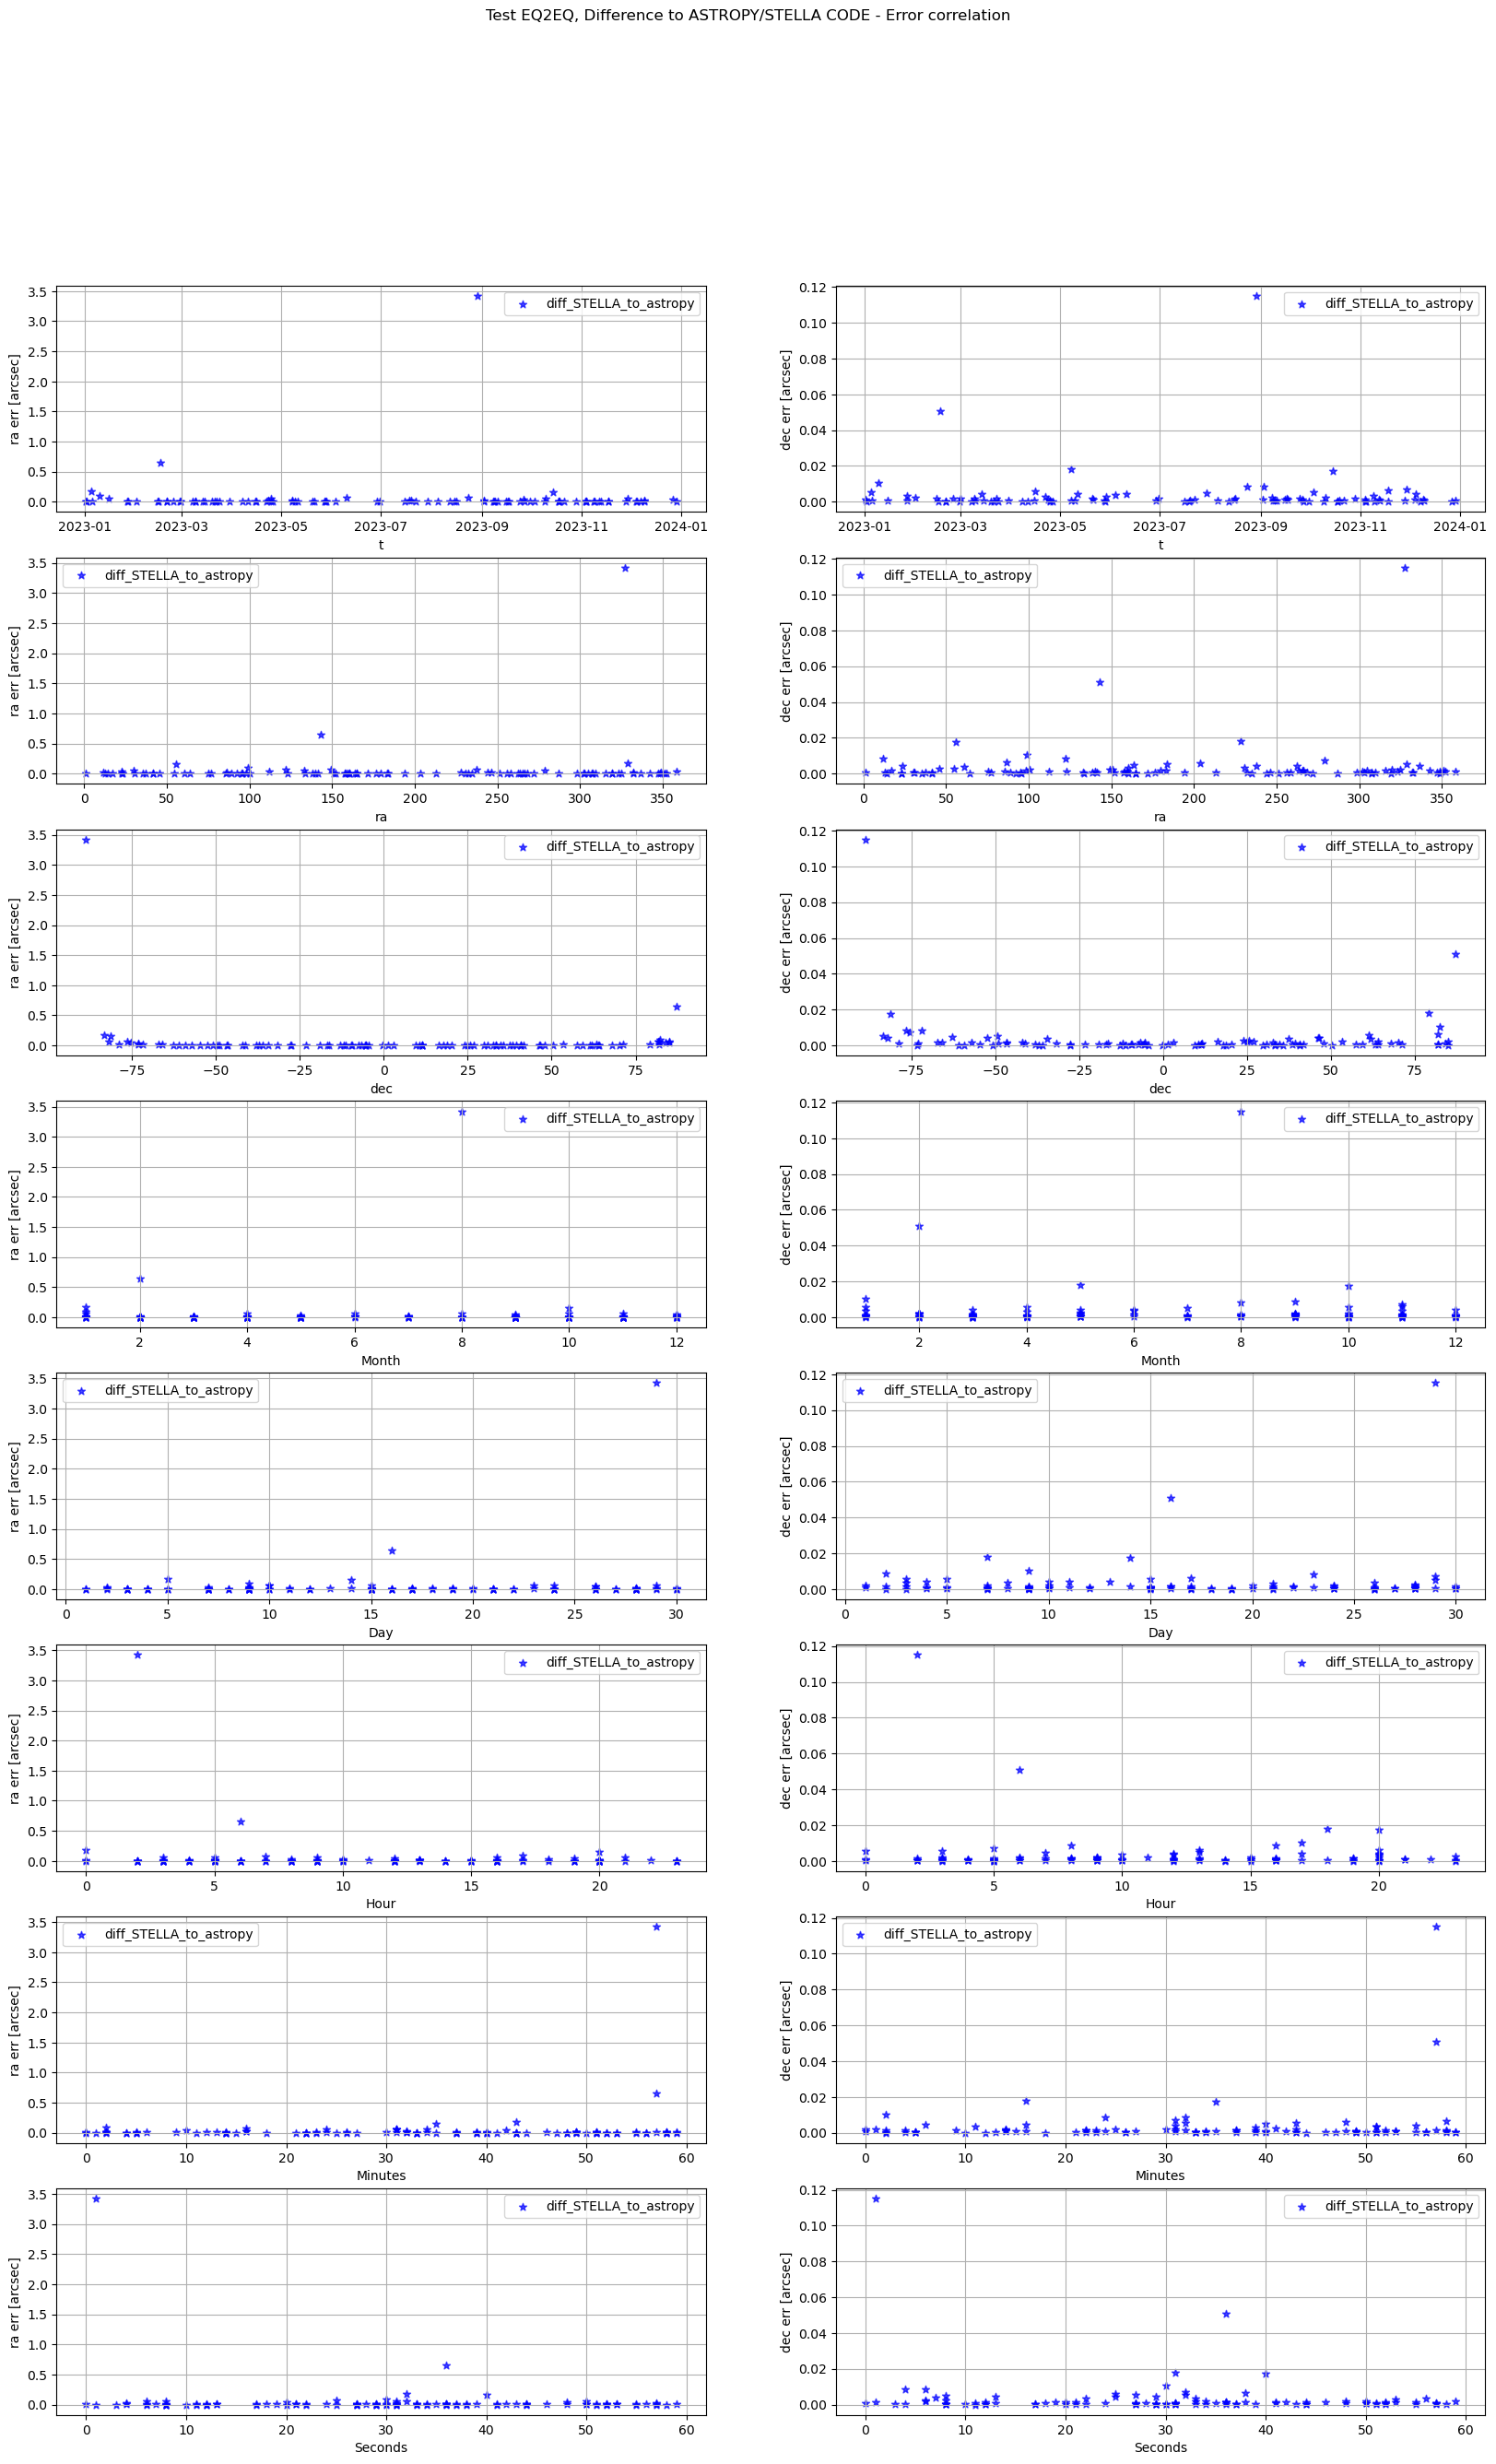

In [64]:
fig, axs = plt.subplots(8, 2, figsize=(20, 30))
fig.suptitle('Test EQ2EQ, Difference to ASTROPY/STELLA CODE - Error correlation')
axs[0,0].scatter(times, err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('ra err [arcsec]')
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].scatter(times, err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[0,1].set_xlabel('t')
axs[0,1].set_ylabel('dec err [arcsec]')
axs[0,1].legend()
axs[0,1].grid()

axs[1,0].scatter(data_in[:,0], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[1,0].set_xlabel('ra')
axs[1,0].set_ylabel('ra err [arcsec]')
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].scatter(data_in[:,0], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[1,1].set_xlabel('ra')
axs[1,1].set_ylabel('dec err [arcsec]')
axs[1,1].legend()
axs[1,1].grid()

axs[2,0].scatter(data_in[:,1], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[2,0].set_xlabel('dec')
axs[2,0].set_ylabel('ra err [arcsec]')
axs[2,0].legend()
axs[2,0].grid()

axs[2,1].scatter(data_in[:,1], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[2,1].set_xlabel('dec')
axs[2,1].set_ylabel('dec err [arcsec]')
axs[2,1].legend()
axs[2,1].grid()

axs[3,0].scatter([m.month for m in times], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[3,0].set_xlabel('Month')
axs[3,0].set_ylabel('ra err [arcsec]')
axs[3,0].legend()
axs[3,0].grid()

axs[3,1].scatter([m.month for m in times], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[3,1].set_xlabel('Month')
axs[3,1].set_ylabel('dec err [arcsec]')
axs[3,1].legend()
axs[3,1].grid()

axs[4,0].scatter([m.day for m in times], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[4,0].set_xlabel('Day')
axs[4,0].set_ylabel('ra err [arcsec]')
axs[4,0].legend()
axs[4,0].grid()

axs[4,1].scatter([m.day for m in times], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[4,1].set_xlabel('Day')
axs[4,1].set_ylabel('dec err [arcsec]')
axs[4,1].legend()
axs[4,1].grid()

axs[5,0].scatter([m.hour for m in times], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[5,0].set_xlabel('Hour')
axs[5,0].set_ylabel('ra err [arcsec]')
axs[5,0].legend()
axs[5,0].grid()

axs[5,1].scatter([m.hour for m in times], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[5,1].set_xlabel('Hour')
axs[5,1].set_ylabel('dec err [arcsec]')
axs[5,1].legend()
axs[5,1].grid()

axs[6,0].scatter([m.minute for m in times], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[6,0].set_xlabel('Minutes')
axs[6,0].set_ylabel('ra err [arcsec]')
axs[6,0].legend()
axs[6,0].grid()

axs[6,1].scatter([m.minute for m in times], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[6,1].set_xlabel('Minutes')
axs[6,1].set_ylabel('dec err [arcsec]')
axs[6,1].legend()
axs[6,1].grid()

axs[7,0].scatter([m.second for m in times], err[:,0,0], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[7,0].set_xlabel('Seconds')
axs[7,0].set_ylabel('ra err [arcsec]')
axs[7,0].legend()
axs[7,0].grid()

axs[7,1].scatter([m.second for m in times], err[:,0,1], marker='*', alpha=0.7, c='blue', label='diff_STELLA_to_astropy')
axs[7,1].set_xlabel('Seconds')
axs[7,1].set_ylabel('dec err [arcsec]')
axs[7,1].legend()
axs[7,1].grid()

plt.show()